# Data Loading and Preprocessing

* No data augmentation was used
* models evaluate the entire test directory
* adam optimiser
* 10 epochs only

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# path to dataset directories
train_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train"
validation_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Validation"
test_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Test"

# # data generators
# train_datagen = ImageDataGenerator(rescale=1./255)
# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size and img size
batch_size = 64

# Load and preprocess the training dataset
train_data_v2M = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(260, 260),  #efficientnet- 260x260
    batch_size=batch_size,
)
train_data_x = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(299, 299),  # Xception requires input size of 299x299
    batch_size=batch_size  # Set class_mode according to your dataset
)

# Load and preprocess the validation dataset
validation_data_v2M = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(260, 260),
    batch_size=batch_size
)
validation_data_x = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(299, 299),
    batch_size=batch_size
)

test_data_v2M = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(260, 260),  #efficientnet- 260x260
    batch_size=batch_size,
)
test_data_x = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(299, 299),  # Xception requires input size of 299x299
    batch_size=batch_size  # Set class_mode according to your dataset
)

Found 140002 files belonging to 2 classes.
Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.


# Xception

In [6]:
import keras
from keras.applications import Xception
from keras.optimizers import Adam
import torch
import pandas as pd

# Load the pre-trained Xception model without the top layers
base_model = Xception(weights='imagenet', input_shape=(299, 299, 3), include_top=False)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add a new output layer for binary classification
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)  # 2 classes for binary classification

# Create the fine-tuned model
model = keras.models.Model(inputs=base_model.input, outputs=outputs)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
with tf.device('/GPU:0'):
    history = model.fit(train_data_x, epochs=10, validation_data=validation_data_x)
    
model.save('xception.h5')

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)


# Evaluate the model on the test set
with tf.device('/GPU:0'):
    loss, accuracy = model.evaluate(test_data_x)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')


Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 677s 306ms/step - accuracy: 0.6230 - loss: 0.9860 - val_accuracy: 0.6989 - val_loss: 0.5995
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 648s 296ms/step - accuracy: 0.6887 - loss: 0.6494 - val_accuracy: 0.6998 - val_loss: 0.6169
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 648s 296ms/step - accuracy: 0.6956 - loss: 0.6242 - val_accuracy: 0.6640 - val_loss: 0.7417
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 648s 296ms/step - accuracy: 0.7068 - loss: 0.5979 - val_accuracy: 0.6944 - val_loss: 0.6289
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 649s 296ms/step - accuracy: 0.7011 - loss: 0.6173 - val_accuracy: 0.6555 - val_loss: 0.6855
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 648s 296ms/step - accuracy: 0.7016 - loss: 0.6137 - val_accuracy: 0.7080 - val_loss: 0.5898
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 650s 297ms/step - accuracy: 0.7043 - loss: 0.6085 - val_accuracy: 0.6995 - val_loss: 0.6007
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 648s 296ms/step - ac

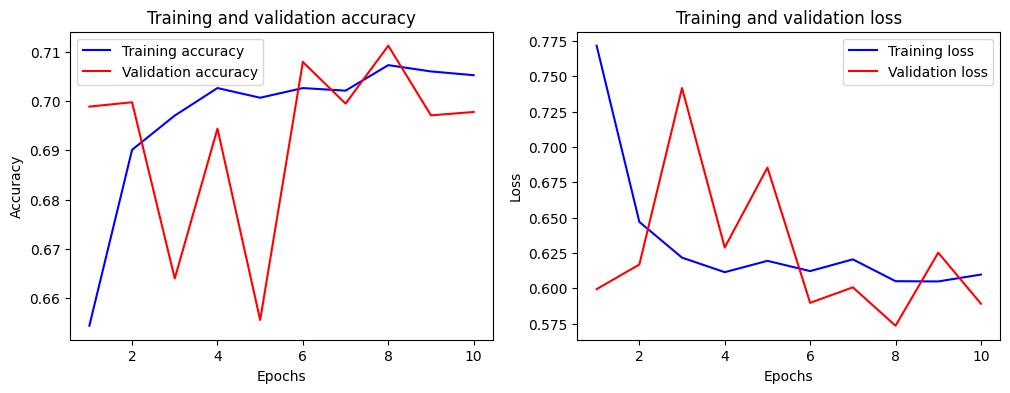

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.applications import Xception
from keras.optimizers import Adam
import tensorflow as tf
def learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy per epoch
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss per epoch
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

learning_curves(history)

# EfficientNetV2M

In [9]:
import tensorflow.keras as keras
from tensorflow.keras.applications import EfficientNetV2M
from tensorflow.keras.optimizers import Adam

# Step 1: Load the EfficientNetV2-M model
model = EfficientNetV2M(weights='imagenet', input_shape=(260, 260, 3), include_top=False)

# Step 2: Freeze the convolutional base
model.trainable = False

# Step 3: Add custom classification head
x = keras.layers.GlobalAveragePooling2D()(model.output)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)

# Step 4: Compile the model
model = keras.models.Model(inputs=model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Step 5: Train the model
with tf.device('/GPU:0'):
    history = model.fit(train_data_v2M, epochs=10, validation_data=validation_data_v2M)

model.save('v2m.h5')

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_v2m.csv', index=False)


# Evaluate the model on the test set
with tf.device('/GPU:0'):
    loss, accuracy = model.evaluate(test_data_v2M)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')


214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step
Epoch 1/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 995s 392ms/step - accuracy: 0.7188 - loss: 0.5461 - val_accuracy: 0.7643 - val_loss: 0.4839
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 743s 331ms/step - accuracy: 0.7634 - loss: 0.4867 - val_accuracy: 0.7730 - val_loss: 0.4710
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 726s 332ms/step - accuracy: 0.7695 - loss: 0.4768 - val_accuracy: 0.7760 - val_loss: 0.4672
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 725s 331ms/step - accuracy: 0.7727 - loss: 0.4709 - val_accuracy: 0.7793 - val_loss: 0.4602
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 723s 330ms/step - accuracy: 0.7773 - loss: 0.4666 - val_accuracy: 0.7804 - val_loss: 0.4587
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 726s 331ms/step - accuracy: 0.7771 - loss: 0.4648 - val_accuracy: 0.7809 - val_loss: 0.4584
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 723s 330ms/step - accuracy: 0.7780 - loss: 0.4634 - val_accuracy: 0.7805 - val_loss: 0.4588
Epoch 8/1

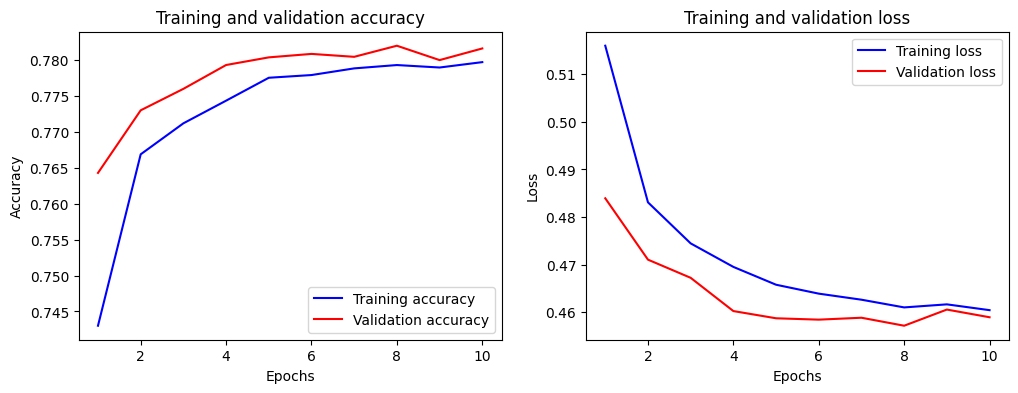

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.applications import Xception
from keras.optimizers import Adam
import tensorflow as tf
def learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy per epoch
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss per epoch
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

learning_curves(history)

# EfficientNetV2S

In [3]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.optimizers import Adam
import torch
import pandas as pd


# path to dataset directories
train_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Train"
validation_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Validation"
test_dir = "/kaggle/input/deepfake-and-real-images/Dataset/Test"

# # data generators
# train_datagen = ImageDataGenerator(rescale=1./255)
# validation_datagen = ImageDataGenerator(rescale=1./255)
# test_datagen = ImageDataGenerator(rescale=1./255)

# Set batch size and img size
batch_size = 64

# Load and preprocess the training dataset
train_data_v2S = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(300, 300), 
    batch_size=batch_size,
)

# Load and preprocess the validation dataset
validation_data_v2S = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    image_size=(300, 300),
    batch_size=batch_size
)

test_data_v2S = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(300, 300),  
    batch_size=batch_size,
)

model = EfficientNetV2S(weights='imagenet', input_shape=(300, 300, 3), include_top=False)

# Freeze the convolutional base
model.trainable = False

# custom classification head
x = keras.layers.GlobalAveragePooling2D()(model.output)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)


model = keras.models.Model(inputs=model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


with tf.device('/GPU:0'):
    history = model.fit(train_data_v2S, epochs=10, validation_data=validation_data_v2S)

model.save('v2s.h5')

history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history_v2s.csv', index=False)


# Evaluate the model on the test set
with tf.device('/GPU:0'):
    loss, accuracy = model.evaluate(test_data_v2S)
    print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%')


Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
Epoch 1/10


I0000 00:00:1719565340.163080     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2188/2188 ━━━━━━━━━━━━━━━━━━━━ 701s 278ms/step - accuracy: 0.7296 - loss: 0.5344 - val_accuracy: 0.7905 - val_loss: 0.4515
Epoch 2/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 523s 239ms/step - accuracy: 0.7751 - loss: 0.4689 - val_accuracy: 0.7988 - val_loss: 0.4379
Epoch 3/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 522s 238ms/step - accuracy: 0.7846 - loss: 0.4542 - val_accuracy: 0.7993 - val_loss: 0.4352
Epoch 4/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 522s 238ms/step - accuracy: 0.7876 - loss: 0.4463 - val_accuracy: 0.8036 - val_loss: 0.4288
Epoch 5/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 522s 239ms/step - accuracy: 0.7904 - loss: 0.4433 - val_accuracy: 0.8044 - val_loss: 0.4267
Epoch 6/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 522s 238ms/step - accuracy: 0.7933 - loss: 0.4377 - val_accuracy: 0.8022 - val_loss: 0.4299
Epoch 7/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 522s 238ms/step - accuracy: 0.7922 - loss: 0.4385 - val_accuracy: 0.8046 - val_loss: 0.4259
Epoch 8/10
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 522s 238ms/step - accuracy: 0.7

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from keras.optimizers import Adam
import tensorflow as tf
def learning_curves(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(acc) + 1)
    
    # Plot training and validation accuracy per epoch
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot training and validation loss per epoch
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
